<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [6]</a>'.</span>

# Gulf Guinea Toy
**Mapping CDR signals within Gulf Guinea Toy**: This notebook maps the fraction of CO2 uptake occuring within a finite regional domain using the global atlas estimates of uptake.

## Import Libraries

Load the Python packages for data handling, ROMS-Tools grids, atlas utilities, and helper functions.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import xarray as xr

import roms_tools as rt

import cdr_atlas
import parsers
import utils

/global/homes/m/mattlong/.conda/envs/atlas-calcs/lib/python3.13/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


## Configure Inputs and Define the Regional Grid

In [2]:
domain_name = "test-dummy"
grid_yaml = "tests/_grid.yml"
injection_year = 1999
injection_month = 1
n_test = None
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "scheduler_file": None,
    "n_nodes": 1,
    "n_tasks_per_node": 128,
    "wallclock": "06:00:00",
}

In [3]:
# Parameters
domain_name = "Gulf Guinea Toy"
grid_yaml = "cson_forge/blueprints/cson_roms-marbl_v0.1_gulf-guinea-toy/_grid.yml"
injection_year = 1999
injection_month = 1
n_test = None
dask_cluster_kwargs = {
    "account": "m4632",
    "queue_name": "premium",
    "n_nodes": 1,
    "n_tasks_per_node": 128,
    "wallclock": "06:00:00",
    "scheduler_file": "/pscratch/sd/m/mattlong/dask/dask_scheduler_file.c03o27d_.json",
}


## Configure Inputs and Define the Regional Grid

Set the domain name, grid YAML, injection settings, and optional `n_test` parameter, then load the ROMS-Tools grid. The grid defines the spatial boundaries of the regional domain and is plotted for a quick visual check.

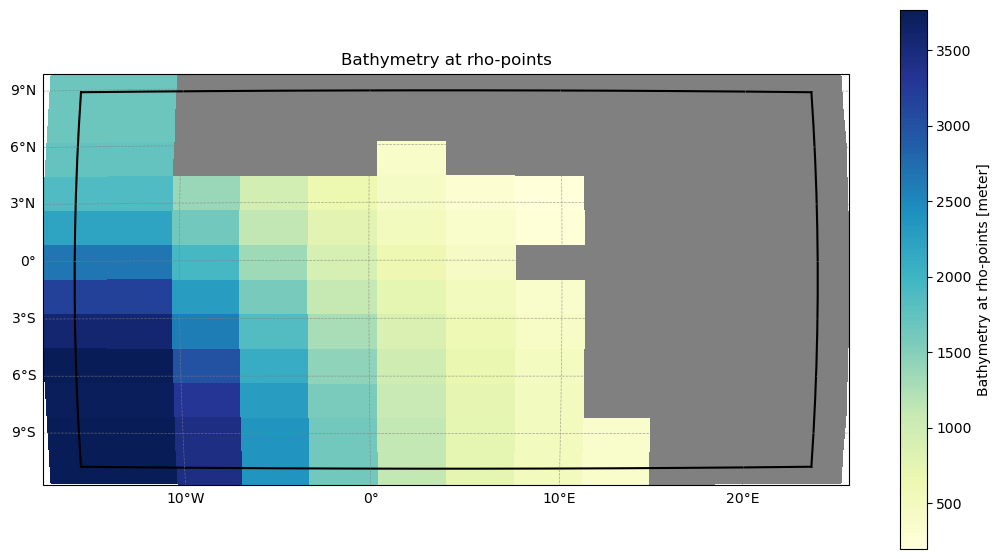

In [4]:
model_grid = parsers.load_roms_tools_object(grid_yaml)
model_grid.plot()

## Create Analyzer and Identify Overlapping Polygons

Select the atlas dataset spec from `cdr_atlas.DATASET_REGISTRY` and initialize `AtlasModelGridAnalyzer`. The analyzer:

1. **Computes a convex hull** of the regional grid using `model_grid.ds.lat_u`/`lon_u`
2. **Performs point‑in‑polygon tests** against the atlas grid
3. **Extracts unique polygon IDs** that overlap the regional domain
4. **Builds a polygon mask** for within‑domain points

This convex‑hull approach captures non‑rectangular domains more accurately than a bounding box. 

Found 19 unique polygon IDs within model grid boundaries
Polygon IDs: [  5.  15.  20.  21.  64.  70.  73.  85. 103. 110. 113. 122. 129. 145.
 358. 487. 575. 600. 632.]


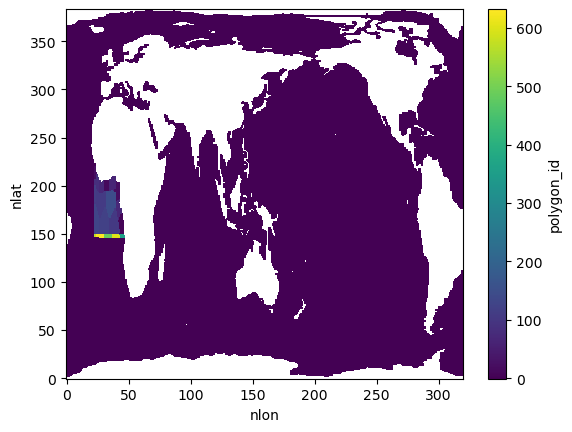

In [5]:
atlas_data = cdr_atlas.DATASET_REGISTRY["oae-efficiency-map_atlas-v0"]

# Create AtlasModelGridAnalyzer instance
analyzer = cdr_atlas.AtlasModelGridAnalyzer(model_grid, atlas_data)

# Get polygon IDs within model grid boundaries
print(f"Found {len(analyzer.polygon_ids_in_bounds)} unique polygon IDs within model grid boundaries")
print(f"Polygon IDs: {analyzer.polygon_ids_in_bounds[:100]}..." if len(analyzer.polygon_ids_in_bounds) > 100 else f"Polygon IDs: {analyzer.polygon_ids_in_bounds}")

analyzer.polygon_id_mask.plot(vmin=-1, vmax=analyzer.polygon_id_mask.max())

## Start Dask Cluster and Test a Single Polygon

A Dask cluster is created (if available) for distributed operations. Then we compute cumulative CO2 uptake for a single polygon using `n_test=3`, which limits the analysis to the first three files in the atlas sequence.

The integration:

1. **Ensures cached files** via the dataset spec
2. **Calculates the additional CO2 flux** (`FG_CO2 - FG_ALT_CO2`)
3. **Integrates over space and time** using:
   - Area weighting with `TAREA`
   - Time weighting with days per month
   - Spatial masking to the regional domain
4. **Computes cumulative integrals** over elapsed time

The outputs include total uptake, uptake within the regional grid, and the fraction captured.

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [6]:
cluster = utils.dask_cluster(**dask_cluster_kwargs)
cluster

RuntimeError: Failed to connect to scheduler after 12 attempts: /pscratch/sd/m/mattlong/dask/dask_scheduler_file.c03o27d_.json

In [ ]:
%%time
# Integrate FG_CO2 for polygon 000 using the first 3 files in the sequence
results = analyzer.integrate_fg_co2_polygon_by_id(
    polygon_id=analyzer.polygon_ids_in_bounds[-1],
    injection_year=injection_year,
    injection_month=injection_month,
    n_test=3,
)

print("FG_CO2 Integration Results:")
print(f"  Total integrated FG_CO2: {results['total'].values[-1]:.2e}")
print(f"  Within model grid: {results['within_grid'].values[-1]:.2e}")
print(f"  Fraction within grid: {results['fraction'].values[-1]:.2%}")

## Integrate CO<sub>2</sub> Flux for All Overlapping Polygons

Compute cumulative CO2 uptake for every polygon that overlaps the regional domain. Results are concatenated along `polygon_id`, yielding a dataset with dimensions `(polygon_id, elapsed_time)`.

In [ ]:
%%time
ds = analyzer.integrate_fg_co2_polygons_within_boundaries(
    injection_year=injection_year,
    injection_month=injection_month,
    n_test=n_test,
)   
ds

## Visualize Fraction of Uptake within the Regional Domain

Map the fraction of CO2 uptake captured within the regional domain for each polygon. The map highlights where a larger share of uptake falls inside the regional grid, helping assess how well the regional domain captures atlas signals.

In [ ]:
analyzer.set_field_within_boundaries(ds.fraction.isel(elapsed_time=-1)).plot(cmap="RdBu_r")


In [ ]:
# check if LocalCluster is running and shutdown
if cluster.local_cluster:
    cluster.shutdown()